# ex8: Anomaly Detection

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
import utils
import warnings
warnings.filterwarnings('ignore')

## Part 1: Load Example Dataset

X: (307, 2)
Xval: (307, 2)
yval: (307, 1)


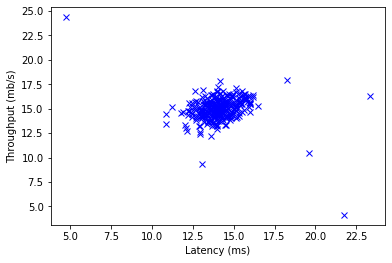

In [2]:
data = loadmat('ex8/ex8data1.mat')
X = data['X']
Xval, yval = data['Xval'], data['yval']

print('X:', X.shape)
print('Xval:', Xval.shape)
print('yval:', yval.shape)

plt.plot(X[:,0], X[:,1], 'bx')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Part 2: Estimate the dataset statistics

In [3]:
def estimateGaussian(X):
    m, n = X.shape
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # =========== code here ============
    mu = np.mean(X, axis=0)
    sigma2 = np.square(np.std(X, axis=0))
    # ==================================

    return mu, sigma2


def multivariateGaussian(X, mu, sigma2):
    k = mu.size
    sigma2 = np.diag(sigma2)
    X = X - mu
    power = -0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1) # 没太明白这
    p = 1 / (2 * np.pi) ** (k / 2) / np.linalg.det(sigma2) ** 0.5 * np.exp(power)
    return p


def visualizeFit(X, mu, sigma2):
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariateGaussian(np.c_[X1.ravel(), X2.ravel()], mu, sigma2)
    Z = Z.reshape(X1.shape)
    plt.plot(X[:,0], X[:,1], 'bx')
    plt.contour(X1, X2, Z, [10 ** p for p in np.arange(-20., 2, 3)], cmap='cool')

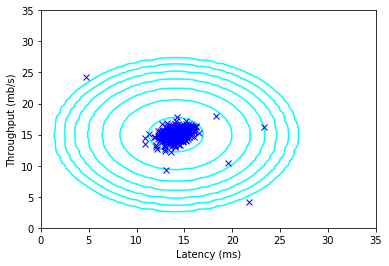

In [4]:
mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

visualizeFit(X, mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

## Part 3: Find Outliers

In [5]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    # for epsilon in 10**np.linspace(np.log10(min(pval)), np.log10(max(pval)), 1000):
    for epsilon in np.linspace(min(pval), max(pval), 1000):

        # =========== code here ============
        tp = np.sum((yval.ravel() == 1) & (pval.ravel() < epsilon))
        fp = np.sum((yval.ravel() == 0) & (pval.ravel() < epsilon))
        fn = np.sum((yval.ravel() == 1) & (pval.ravel() > epsilon))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        F1 = 2 * precision * recall / (precision + recall)
        # ==================================

        if F1 >= bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [6]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon : %.5e' % epsilon)
print('Bset F1-score: %.10f' % F1)

Best epsilon : 4.49993e-04
Bset F1-score: 0.8750000000


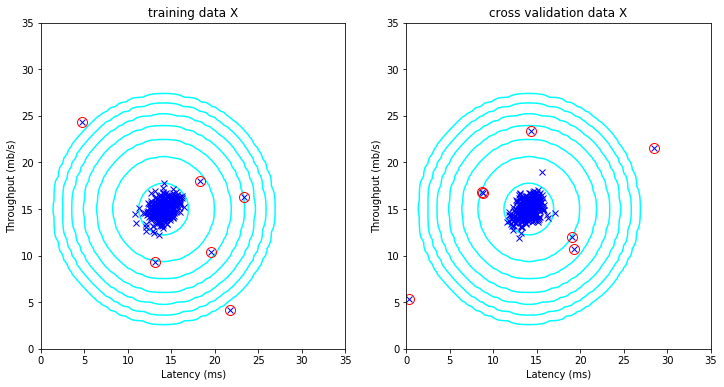

In [7]:
outliers = p < epsilon
outliersVal = pval < epsilon

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
visualizeFit(X, mu, sigma2)
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', mfc='None', ms=10)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('training data X')

plt.subplot(1,2,2)
visualizeFit(Xval, mu, sigma2)
plt.plot(Xval[outliersVal, 0], Xval[outliersVal, 1], 'ro', mfc='None', ms=10)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('cross validation data X')

plt.show()

## Part 4: Multidimensional Outliers

In [8]:
data = loadmat('ex8/ex8data2.mat')
X = data['X']
Xval, yval = data['Xval'], data['yval']

mu, sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon : %.5e' % epsilon)
print('Bset F1-score: %.10f' % F1)
print('#outliers found: %d' % np.sum(p < epsilon))

Best epsilon : 1.37861e-18
Bset F1-score: 0.6153846154
#outliers found: 117


# ex8: Recommender Systems

## Part 1: Loading movie ratings dataset

Y: (1682, 943)  R: (1682, 943)
Average rating for movie 1 (Toy Story): 3.878 / 5


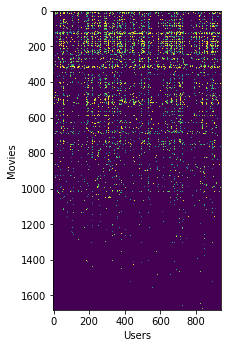

In [9]:
data = loadmat('ex8/ex8_movies.mat')
Y, R = data['Y'], data['R']
print('Y:', Y.shape,' R:', R.shape)
print('Average rating for movie 1 (Toy Story): %.3f / 5' % np.mean(Y[0, R[0, :] == 1]))

plt.figure(figsize=(5.5,5.5))
plt.imshow(Y)
plt.xlabel('Users')
plt.ylabel('Movies')
plt.show()

## Part 2: Collaborative Filtering Cost Function

In [10]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamb=0.):
    X = params[ : num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features : ].reshape(num_users, num_features)
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # =========== code here ============
    Delta = np.square(np.dot(X, Theta.T) - Y) * R
    J = 1/2 * np.sum(Delta) + lamb/2 * (np.sum(np.square(Theta)) + np.sum(np.square(X)))
    
    Yp = np.dot(X, Theta.T) - Y
    X_grad = np.dot(Yp * R, Theta) + lamb * X
    Theta_grad = np.dot((Yp * R).T, X) + lamb * Theta
    # ==================================

    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])

    return J, grad

In [11]:
data = loadmat('ex8/ex8_movieParams.mat')
X, Theta = data['X'], data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

nu = 4
nm = 5
nf = 3

Xtmp = X[:nm, :nf]
Ttmp = Theta[:nu, :nf]
Ytmp = Y[:nm, :nu]
Rtmp = R[:nm, :nu]

J,_ = cofiCostFunc(np.concatenate([Xtmp.ravel(), Ttmp.ravel()]), Ytmp, Rtmp, nu, nm, nf)
print('Cost at loaded parameters %.2f. (22.22 correct)' % J)

J,_ = cofiCostFunc(np.concatenate([Xtmp.ravel(), Ttmp.ravel()]), Ytmp, Rtmp, nu, nm, nf, lamb=1.5)
print('Regularized Cost %.2f. (31.34 correct)' % J)

Cost at loaded parameters 22.22. (22.22 correct)
Regularized Cost 31.34. (31.34 correct)


## Part 3: Collaborative Filtering Gradient

In [12]:
utils.checkCostFunction(cofiCostFunc)
utils.checkCostFunction(cofiCostFunc, 5)

[[ 2.25133595e-02  2.25133595e-02]
 [-2.15021087e+00 -2.15021087e+00]
 [-2.28837106e+00 -2.28837106e+00]
 [ 1.91407754e+00  1.91407754e+00]
 [-4.08101374e+00 -4.08101374e+00]
 [ 1.55447316e+00  1.55447316e+00]
 [ 8.44103618e-03  8.44103618e-03]
 [-1.88645769e-03 -1.88645769e-03]
 [ 3.18662798e-01  3.18662798e-01]
 [ 1.87072912e+00  1.87072912e+00]
 [-6.03772006e-01 -6.03772006e-01]
 [ 6.45810011e+00  6.45810011e+00]
 [-4.83187370e+00 -4.83187370e+00]
 [ 1.94651612e+00  1.94651612e+00]
 [-1.18100785e+00 -1.18100785e+00]
 [ 2.75509821e+00  2.75509821e+00]
 [-1.47900020e+00 -1.47900020e+00]
 [-1.91771273e+00 -1.91771273e+00]
 [-1.30591509e+00 -1.30591509e+00]
 [ 1.98851070e-02  1.98851070e-02]
 [-1.38329301e+00 -1.38329301e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-1.87137103e+00 -1.87137103e+00]
 [ 7.93097228e-01  7.93097228e-01]
 [ 5.29267463e-01  5.29267463e-01]]

The above two columns you get should be very similar.

## Part 6: Entering ratings for a new user 

In [13]:
def loadMovieList():
    with open('ex8/movie_ids.txt', 'r', encoding='latin-1') as f:
        txt = f.readlines()
    movies = []
    for line in txt:
        pieces = line.split()
        movies.append(' '.join(pieces[1:]).strip())
    return movies

movieList = loadMovieList()
print('\n'.join(movieList[:10]))

Toy Story (1995)
GoldenEye (1995)
Four Rooms (1995)
Get Shorty (1995)
Copycat (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Twelve Monkeys (1995)
Babe (1995)
Dead Man Walking (1995)
Richard III (1995)


In [14]:
num_movies = len(movieList)
my_ratings = np.zeros(num_movies)

my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('You entered new user ratings:')
print('--------------------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d* : << %s >>' % (my_ratings[i], movieList[i]))
print('--------------------------------------')

You entered new user ratings:
--------------------------------------
Rated 4* : << Toy Story (1995) >>
Rated 3* : << Twelve Monkeys (1995) >>
Rated 5* : << Usual Suspects, The (1995) >>
Rated 4* : << Outbreak (1995) >>
Rated 5* : << Shawshank Redemption, The (1994) >>
Rated 3* : << While You Were Sleeping (1995) >>
Rated 5* : << Forrest Gump (1994) >>
Rated 2* : << Silence of the Lambs, The (1991) >>
Rated 4* : << Alien (1979) >>
Rated 5* : << Die Hard 2 (1990) >>
Rated 5* : << Sphere (1998) >>
--------------------------------------


## Part 7: Learning Movie Ratings

In [15]:
data = loadmat('ex8/ex8_movies.mat')
Y, R = data['Y'], data['R']
print('Original ratings:')
print('Y:', Y.shape)
print('R:', R.shape)

Y = np.hstack([my_ratings.reshape(my_ratings.shape[0],1), Y])
R = np.hstack([(my_ratings > 0).reshape(my_ratings.shape[0], 1), R])
print('\nAfter adding my_ratings:')
print('Y:', Y.shape)
print('R:', R.shape)

Original ratings:
Y: (1682, 943)
R: (1682, 943)

After adding my_ratings:
Y: (1682, 944)
R: (1682, 944)


In [16]:
Ynorm, Ymean = utils.normalizeRatings(Y, R)

num_movies, num_users = Y.shape
num_features = 10

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

params = np.concatenate([X.ravel(), Theta.ravel()])
options = {'maxiter':100}
lamb = 10
res = minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users, num_movies, num_features, lamb),
                params, method='TNC', jac=True, options=options)

params = res.x
X = params[:num_movies*num_features].reshape(num_movies, num_features)
Theta = params[num_movies*num_features:].reshape(num_users, num_features)

In [17]:
p = np.dot(X, Theta.T)
preds = p[:, 0] + Ymean

idxs = np.argsort(preds)[::-1]
top_n = 15


print('You entered new user ratings:')
print('--------------------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d* : << %s >>' % (my_ratings[i], movieList[i]))

print('\nTop %d recommendations for you:' % top_n)
print('--------------------------------------')
for i in range(top_n):
    idx = idxs[i]
    print('predict rating %.1f* : << %s >>' % (preds[idx], movieList[idx]))



You entered new user ratings:
--------------------------------------
Rated 4* : << Toy Story (1995) >>
Rated 3* : << Twelve Monkeys (1995) >>
Rated 5* : << Usual Suspects, The (1995) >>
Rated 4* : << Outbreak (1995) >>
Rated 5* : << Shawshank Redemption, The (1994) >>
Rated 3* : << While You Were Sleeping (1995) >>
Rated 5* : << Forrest Gump (1994) >>
Rated 2* : << Silence of the Lambs, The (1991) >>
Rated 4* : << Alien (1979) >>
Rated 5* : << Die Hard 2 (1990) >>
Rated 5* : << Sphere (1998) >>

Top 15 recommendations for you:
--------------------------------------
predict rating 5.0* : << Great Day in Harlem, A (1994) >>
predict rating 5.0* : << Santa with Muscles (1996) >>
predict rating 5.0* : << Saint of Fort Washington, The (1993) >>
predict rating 5.0* : << Someone Else's America (1995) >>
predict rating 5.0* : << Aiqing wansui (1994) >>
predict rating 5.0* : << Star Kid (1997) >>
predict rating 5.0* : << Marlene Dietrich: Shadow and Light (1996) >>
predict rating 5.0* : << Prefo